# EllaBot Report

## Introduction

In a search and rescue problem, an agent is presented a navigation target which it must reach as quickly as possible. In our formulation of the problem, the agent is only allowed to manipulate its linear and angular velocities, which is consistent with the capabilities of the TurtleBots and SegBots. In order to solve this problem, we used Sarsa($\lambda$) with value function approximation and policy gradient methods. We present a comparison of these two methods. However, these methods are inflexible in the face of changing environments. We investigated the use of a lifelong learning algorithm with policy gradients, PG-ELLA.

The code for our world and learning algorithms is available on [our GitHub](http://github.com/EllaBot/). First, the world can be setup as follows:

In [1]:
%matplotlib inline
from worldsim import WorldSim
from worldsim.experiments import experiment_runner
from worldsim.experiments import plot_utils
from worldsim.agents import SarsaAgent, State
from worldsim.tasks import SearchTask
from true_online_td_lambda.optimization import l_bfgs
from random import random
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6

## Sarsa($\lambda$)

We used True Online TD($\lambda$) for our Sarsa() implementation[1]. It has a conceptually simple forward view that can be implemented online inexpensively. Because our problem has continous state and action spaces, we must use a function approximator. We decided to use the Fourier basis[2].

### Learning

For selecting actions, we used an $\epsilon$-greedy policy, where we selected actions that maximize the value function (with probability $1 - \epsilon$), and chose random actions otherwise.

In order to maximize the value function, we needed to find the following, where **S**, **A** correspond to the state and action vectors, respectively.

$$\underset{\textbf{A}} {\mathrm{argmax}} ~\hat{V}(\textbf{S}, \textbf{A}) = \underset{\textbf{A}} {\mathrm{argmax}} ~\theta^{\top}\phi(\textbf{S}, \textbf{A})$$

To solve this, the gradient of the value function, $\hat{V}$, is needed, which can be found by differentiating $\phi$ w.r.t **A**:

$$\phi(\textbf{S}, \textbf{A}) = \cos(\pi \textbf{c} \cdot (\textbf{S}, \textbf{A}))$$

$$\frac{\partial \ \phi(\textbf{S}, \textbf{A})}{\partial \ \textbf{A}} = -\pi\textbf{c}\sin(\pi \textbf{c} \cdot (\textbf{S}, \textbf{A}))$$

So:

$$\nabla_{\textbf{A}}\hat{V}(\textbf{S}, \textbf{A}) = -\theta^{\top}\pi\textbf{c}\sin(\pi \textbf{c} \cdot (\textbf{S}, \textbf{A}))$$

Next, we used a convex optimization method, L-BFGS, to maximize $\hat{V}$. This is a quasi-Newton method which uses hessian approximations to guide convergence.

Now, let's run an experiment with 150 episodes to see if the agent learns:

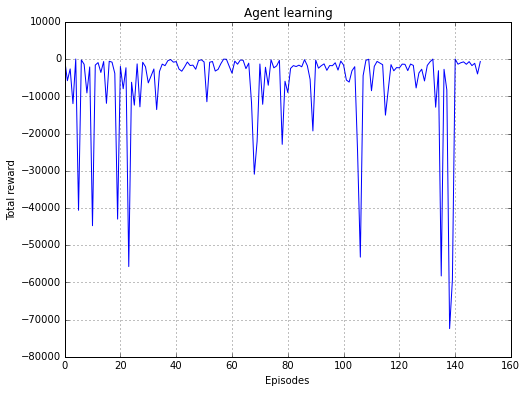

In [2]:
world = WorldSim(10.0, 10.0) # 10m x 10m world
agent = SarsaAgent(world, world.task)
rewards = experiment_runner.run_experiment(agent, world, episodes=150, maximize=l_bfgs.maximize)

# Plot results
plot_utils.plot_rewards(rewards)

Clearly, the agent does not seem to be learning. Upon further investigation, we found that the reason for this happening is because the Fourier basis is a non-convex function. As a result, the convex optimizer gets stuck at local maxima.

The Fourier basis paper talks about tasks that have continuous states, but *discrete* actions, which is why the non-convex nature of the basis is not a problem. However, our task has both continuous states and actions.

We used two approaches to solve this problem. First, we used a naïve brute force approach, where we searched for the maximum by plugging in linear and angular velocities into the value function, in small increments, and choosing the velocities which resulted in the maxium value.

This solution is far from ideal, as it is extremely slow and imprecise. So in our second approach, we combined a brute force search with convex optimization. Essentially, we found the rough maximum via brute force, and then used that rough maximum as the initial guess for L-BFGS. L-BFGS then maximized around that initial point to find the global maximum. This alleviates some of the issues with normal brute force searching: it is faster since the increments need not be very small (since we just want a rough maximum), and it is more accurate since L-BFGS is finding the global maximum at the end.

Now, let's run the experiment again, with our second optimization strategy:

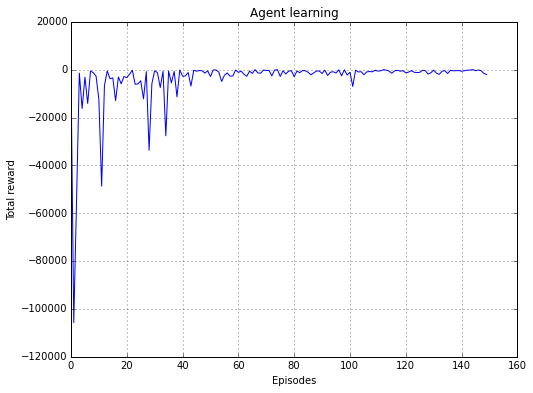

In [3]:
world = WorldSim(10.0, 10.0) # 10m x 10m world
agent = SarsaAgent(world, world.task)
rewards = experiment_runner.run_experiment(agent, world, episodes=150)

# Plot results
plot_utils.plot_rewards(rewards)

Looking at the graph, the agent is learning, since the total episodic reward increases. As further proof, we have measured the number of steps taken to cover the initial distance (distance per step), averaged over 5 agents, and have plotted it with respect to the episodes:

<img src="https://raw.githubusercontent.com/EllaBot/Report/master/images/distanceperstepsplot.png" width="600">

The above graph shows that the agent is able to cover the distance needed to reach the target in fewer steps as the number of episodes increases.

In hindsight, while our second approach is superior to a naïve brute force search, there are still better methods to use. For example, basin hopping [3] is a Monte Carlo method used is many physics and chemistry problems. It finds the global maximum by randomly perturbing coordinates, finding the local maximum, and accepting or rejecting new coordinates based on the Metropolis criterion. This method would be faster than our second approach. Furthermore, taking advantage of GPU computing would greatly speed up optimization.